In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from tqdm import trange
from dataclasses import dataclass
import csv

In [2]:
from module import *

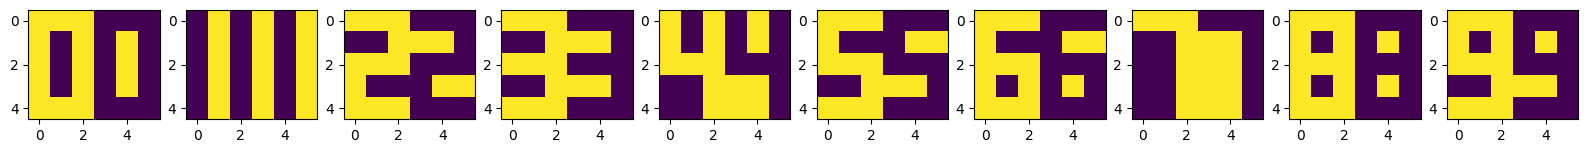

In [3]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    0: "f lr lr lr f",
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}

fig, axs = plt.subplots(1, 10, figsize=(20,20))
for ax, n in zip(axs, numbers_rows.values()):
    ax.imshow(pd.DataFrame(n).values)

In [4]:
from ipywidgets import SelectMultiple, Select, Button, HBox, VBox, Output, IntRangeSlider, Checkbox, Accordion
def ui(data):
    def update_graph(b):
        fig, ax = plt.subplots(figsize=(8,8))
        s = np.concatenate(([x.value for x in select_nodes]))
        if np.isin('---', s):
            s = s[np.where(s != '---')].astype(int)
        for n in s:
            t = data.index.tolist()
            ax.step(t[xw.value[0]:xw.value[1]], data[n][xw.value[0]:xw.value[1]])
        ax.legend([int(n) for n in s])
        with graph:
            graph.clear_output()
            display(plt.show())


    graph = Output()
    layer_select = Select(
        options=net.nodes.layer.unique(),
        value=0,
        description='Слой'
    )

    type_chboxs = []
    for t in net.nodes.type.unique():
        type_chboxs.append(Checkbox(
            value=True,
            description=t,
            disabled=False
        ))
    select_nodes = []
    for t in type_chboxs:
        v = t.value
        if v:
            select_nodes.append(
                SelectMultiple(
                    options=np.insert(np.array(net.nodes.query(f"type=='{t.description}'").index.tolist(),dtype=object), 0, '---'),
                    description=t.description
                )
            )
            select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    def on_layer_change(change):
        select_nodes = []
        for t in type_chboxs:
            v = t.value
            if v:
                select_nodes.append(
                    SelectMultiple(
                        options=np.insert(np.array(net.nodes.query(f"type=={t.description}").index.tolist(),dtype=object), 0, '---'),
                        description=t.description
                    )
                )
                select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    layer_select.observe(on_layer_change, names='value')

    xw = IntRangeSlider(
        min=data.index.min(),
        max=data.index.max(),
        value=(data.index.min(), data.index.max()),
        description='Окно просмотра',
        disabled=False
    )
    select = Accordion(children=[VBox(type_chboxs), VBox(select_nodes)])
    select.selected_index=1
    select.set_title(0, 'Типы')
    select.set_title(1, 'Ноды')
    xw.observe(update_graph, names='value')
    [x.observe(update_graph, names='value') for x in select_nodes]
    draw = Button(description='Draw')
    draw.on_click(update_graph)
    return HBox((VBox((xw,select,draw)), graph))

In [5]:
def draw_network(net):
    import networkx as nx
    edges = []
    pos = {}
    n_in = {}
    for node, (_, priority, listen, cast, __) in net.nodes.iterrows():
        if listen is not None:
            try:
                iter(listen)
            except:
                listen = [listen]
            for l in listen:
                edges.append((l, node))
        if cast is not None:
            try:
                iter(cast)
            except:
                cast = [cast]
            for c in cast:
                edges.append((node, c))
        if priority not in n_in:
            n_in[priority] = 0
        pos[node] = (priority, n_in[priority])
        n_in[priority] += 0.5
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,15))
    options = {
        "font_size": 12,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "blue",
        "linewidths": 2,
        "width": 2,
        "connectionstyle": 'arc3, rad = 0.3'
    }
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    nx.draw_networkx(G, pos, **options)
    plt.show()

In [6]:
params_rows = {
    "tau_leak": 1, 
    "tau_inhibitory": 1,
    "tau_refractory": 1,
    "tau_ltp": 1, 
    "thres": 750,
    "ainc": 30, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": False,
    "wta": True
}
weights_rows = np.array([
    [1, 1, 1, 255, 255, 255],
    [1, 1, 255, 255, 255, 1],
    [1, 255, 1, 255, 1, 255],
    [1, 255, 255, 255, 1, 1],
    [255, 1, 1, 1, 255, 255],
    [255, 1, 255, 1, 255, 1],
    [255, 255, 1, 1, 1, 255],
    [255, 255, 255, 1, 1, 1]
])
labels_rows = [
    "e",
    "r",
    "c",
    "cr",
    "l",
    "lr",
    "lc",
    "f"
]
params_digits = {
    "tau_leak": 50, 
    "tau_inhibitory": 30, 
    "tau_refractory": 300,
    "tau_ltp": 50 ,
    "thres": 500,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
weights_digits = np.array([
    [1, 1, 255, 1, 1, 1, 1, 1],
    [1, 255, 1, 1, 255, 1, 1, 255],
    [1, 1, 1, 1, 1,255, 1, 255]
])

In [13]:
nseq_d = []
nseq_l = []
test_data = [data_rows["off"].copy()]
test_labels = [-1]
a = None
for n in range(3):
    a = n
    test_data+=[x.copy() for x in numbers_rows[a]]
    test_labels+=[a for _ in numbers_rows[a]]
    test_labels.append(-1)
    test_data.append(data_rows["off"].copy())

for d, l in zip(test_data, test_labels):
    if l != -1:
        t = 10
    else:
        t = 50
        
    nseq_d.append(d.copy())
    nseq_l.append(l)
    for i in range(t-1):
        nseq_d.append(data_rows["off"].copy())
        nseq_l.append(l)

test_data = nseq_d
test_labels = nseq_l

In [14]:
data = []
ans = []
net = SpikeNetworkSim(inputs_l=6, dt=1)
net.new_layer(8, weights=weights_rows, **params_rows)
net.new_layer(3, weights=weights_digits, **params_digits) 
out = net.feed_raw(test_data)


In [15]:
print(net.nodes.to_string())

            type                           listening                      broadcasting  priority  layer
0          input                                None                               [6]         0      0
1          input                                None                               [7]         0      0
2          input                                None                               [8]         0      0
3          input                                None                               [9]         0      0
4          input                                None                              [10]         0      0
5          input                                None                              [11]         0      0
6            ltp                                 [0]  [14, 17, 20, 23, 26, 29, 32, 35]         1      0
7            ltp                                 [1]  [14, 17, 20, 23, 26, 29, 32, 35]         1      0
8            ltp                                 [2]  [14, 17, 2

In [16]:
net.weights

,weights,inhibited
12,"[1, 1, 1, 255, 255, 255]",291
15,"[1, 1, 255, 255, 255, 1]",291
18,"[1, 255, 1, 255, 1, 255]",291
21,"[1, 255, 255, 255, 1, 1]",291
24,"[255, 1, 1, 1, 255, 255]",291
27,"[255, 1, 255, 1, 255, 1]",291
30,"[255, 255, 1, 1, 1, 255]",291
33,"[255, 255, 255, 1, 1, 1]",291
52,"[1, 1, 255, 1, 1, 1, 1, 1]",501
55,"[1, 255, 1, 1, 240, 1, 1, 255]",571


In [17]:
ui(out)

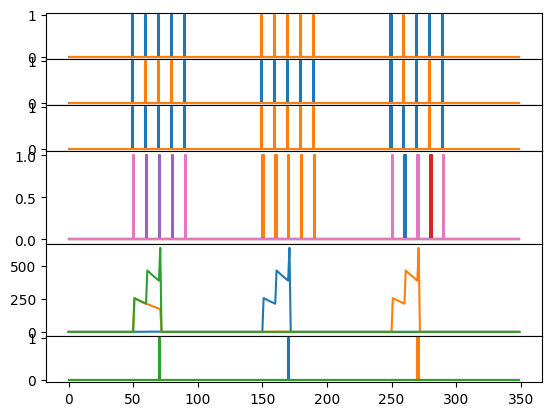

In [57]:
from matplotlib import gridspec


time = out.index.to_list()
in1, in2, in3, nin1, nin2, nin3 = out.loc[:, 0:5].values.transpose()
r1, r2, r3, r4, r5, r6, r7 = out.loc[:, 37:43].values.transpose()
pre0, pre1, pre2 = out.loc[:, 52:58:3].values.transpose()
post0, post1, post2 = out.loc[:, 53:59:3].values.transpose()


gs = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 2, 2, 1]) 

# the first subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
line0, = ax0.step(time, in1)
nline0, = ax0.step(time, nin1)

# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line1, = ax1.step(time, in2)
nline1, = ax1.step(time, nin2)

ax2 = plt.subplot(gs[2], sharex = ax0)
line2, = ax2.step(time, in3)
nline2, = ax2.step(time, nin3)
#ax0.legend((line0, line1), ('red line', 'blue line'), loc='lower left')

ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.step(time, r1, time, r2, time, r3, time, r4, time, r5, time, r6, time, r7)

ax4 = plt.subplot(gs[4], sharex = ax0)
ax4.plot(time, pre0,time, pre1,time, pre2)

ax4 = plt.subplot(gs[5], sharex = ax0)
ax4.step(time, post0,time, post1,time, post2)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()